In [1]:
!export LD_LIBRARY_PATH=/opt/conda/lib
!export XLA_FLAGS=--xla_gpu_cuda_data_dir=/home/jarugula/cuda_data_dir
!export PATH=/usr/local/cuda-11.7/bin:${PATH}

In [ ]:
# import the libraries

import logging
import warnings
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
import random
from tqdm import tqdm
import pandas as pd

import h5py
import os
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape,Conv1D,Flatten,Dense, Lambda
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  pass
from sklearn.utils import shuffle
AUTOTUNE = tf.data.AUTOTUNE
from sklearn.preprocessing import StandardScaler
import tqdm
import gc
import seaborn as sns
from cycler import cycler

os.environ['PATH']=os.environ['PATH']+':/usr/local/cuda/bin'
os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/home/jarugula/cuda_data_dir'

In [3]:
# define your plot style

best_style = {
    # "font.sans-serif": ["TeX Gyre Heros", "Helvetica", "Arial"],
    "font.family": "sans-serif",
    "mathtext.fontset": "custom",
    "mathtext.rm": "TeX Gyre Heros",
    "mathtext.bf": "TeX Gyre Heros:bold",
    "mathtext.sf": "TeX Gyre Heros",
    "mathtext.it": "TeX Gyre Heros:italic",
    "mathtext.tt": "TeX Gyre Heros",
    "mathtext.cal": "TeX Gyre Heros",
    "mathtext.default": "regular",
    "figure.figsize": (10.0, 10.0),
    "font.size": 26,
    #"text.usetex": True,
    "axes.labelsize": "medium",
    "axes.unicode_minus": False,
    "xtick.labelsize": "small",
    "ytick.labelsize": "small",
    "legend.fontsize": "small",
    "legend.handlelength": 1.5,
    "legend.borderpad": 0.5,
    "xtick.direction": "in",
    "xtick.major.size": 12,
    "xtick.minor.size": 6,
    "xtick.major.pad": 6,
    "xtick.top": True,
    "xtick.major.top": True,
    "xtick.major.bottom": True,
    "xtick.minor.top": True,
    "xtick.minor.bottom": True,
    "xtick.minor.visible": True,
    "ytick.direction": "in",
    "ytick.major.size": 12,
    "ytick.minor.size": 6.0,
    "ytick.right": True,
    "ytick.major.left": True,
    "ytick.major.right": True,
    "ytick.minor.left": True,
    "ytick.minor.right": True,
    "ytick.minor.visible": True,
    "grid.alpha": 0.8,
    "grid.linestyle": ":",
    "axes.linewidth": 2,
    "savefig.transparent": False,
}
plt.style.use(best_style)
cols = ["#5790fc", "#f89c20", "#e42536", "#964a8b", "#9c9ca1", "#7a21dd"]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cols)

In [ ]:
# The training data of 1M strong lens images

model_name = 'working_model_1M-2-034_seed38_v2.keras'
model = tf.keras.models.load_model(model_name)

data_path = '/deepskieslab/stronglensing/hsbi/datasets/'
image_dir = 'w0_8param_fixzv_train_1M'
column_name = "w0-g" # Dark energy equation-of-state parameter 

In [5]:
# Read the images and metadata

if os.path.isdir(data_path+image_dir):
    images = np.load(data_path+image_dir+'/CONFIGURATION_1_images.npy', allow_pickle=True)
    metadata = pd.read_csv(data_path+image_dir+'/CONFIGURATION_1_metadata.csv')
else:
   print("Data not found")

In [6]:
images = np.einsum('lkij->lijk',images)
theta = metadata[column_name].to_numpy()

In [7]:
# normalize image each image by the sum of all pixels, make it such that the sum of all pixels is 1024 (32 X32)
images = 1024*(images/np.sum(images, axis=(1,2), keepdims=True))

# manually standardies pixels across all images. 
# In this analysis we do not standerdize the images and parameter. Hence we use mean=0 and std=1.0

images = images.reshape(images.shape[0], -1)
# means_image = np.mean(images, axis=0)
# std_image = np.std(images, axis=0)
means_image = 0.0
std_image = 1.0
images = (images - means_image) / std_image
images = images.reshape(images.shape[0], 32, 32, 1)


#manually standardize the theta (w)
mean_theta = 0.0 
std_theta = 1.0 
theta = (theta - mean_theta)/std_theta

### Split the data into train and test

In [ ]:
x_train , x_test, theta_train, theta_test, y_train, y_test = train_test_split(images, theta, np.ones_like(theta), test_size=0.2, random_state=0)
true_test_theta = np.copy(theta_test)
true_test_theta = true_test_theta*std_theta + mean_theta

del images, theta
gc.collect()

### Calculate the Analytical Posterior 

The analytical equation to calculate the posterior is given by

\begin{equation}
\begin{split}
    p(w|\{x\}) &= \frac{p(w)~\prod_{i}r(x_i|w)}{\int dw^{\prime}~ p(w^{\prime})~\prod_{i}r(x_{i}|w^{\prime})},\\
        &= p(w)~\left( \int dw^{\prime}~p(w^{\prime})~\prod_{i}\frac{r(x_i|w^{\prime})}{r(x_i|w)} \right)^{-1}.
\end{split}
\end{equation}

```likelihood_diff``` function calculates $log\ r(x|w^{\prime}) - log\ r(x|w)$  for one image $x$ 

This is same as calculating $\frac{r(x_i|w^{\prime})}{r(x_i|w)}$ in the posterior equation

```get_joint_likelihood``` function calculates  $\sum_{i} log\ r(x_{i}|w^{\prime}) - log\ r(x_{i}|w)$ for a population of strong lens images $\{x_{i}\}$

This is same as calculating $\prod_{i}\frac{r(x_i|w^{\prime})}{r(x_i|w)}$ in the posterior equation

```get_joint_posterior``` calculates the sum of posterior for all the theta ($w$) values and gives the inverse of the sum as shown in the equation

In [10]:
import numba as nb

@nb.jit
def get_logr_distribution(model, images, sample_theta):
    '''
    Function to predict the log likelihood-to-evidence ratio (logr) of the test data

    Input:
    model: The trained model 
    images: test images
    sample_theta: a list of theta values to compute logr for
    '''
    output_probs = []
    for image in images:
        test_image_array = np.concatenate([image[np.newaxis, :]]*len(sample_theta), axis=0)
        output = model.predict([test_image_array, sample_theta], verbose=0).flatten()
        output_probs.append(output)
    return np.array(output_probs)

class Posterior:
    def __init__(self, lnr, thetas):
        self.lnr = lnr
        self.thetas = thetas

    def likelihood_diff(self, image_index):
        # exp_diff_lnr = np.empty((len(self.thetas), len(self.thetas)))
        diff_lnr_list = np.empty((len(self.thetas), len(self.thetas)))
        for i in range(len(self.thetas)):
            diff_lnr = self.lnr[image_index, i] - self.lnr[image_index]
            # exp_diff_lnr[i] = np.exp(diff_lnr)
            diff_lnr_list[i] = diff_lnr
        # return exp_diff_lnr
        return diff_lnr_list

    def get_joint_likelihood(self, n_images):
        likelihood = np.empty((n_images, len(self.thetas), len(self.thetas)))
        for i in range(n_images):
            likelihood[i] = self.likelihood_diff(i)
        # joint_likelihood = np.prod(likelihood, axis=0)
        joint_likelihood = np.sum(likelihood, axis=0)
        joint_likelihood = np.exp(joint_likelihood)
        return joint_likelihood
    
    def get_joint_posterior(self, n_images):
        joint_likelihood = self.get_joint_likelihood(n_images)
        joint_posterior = 1. / np.sum(joint_likelihood, axis=0)
        return joint_posterior
    
def get_joint_posterior_probability(lnr, thetas, n_images):
    '''
    Function to sample from the posterior probability distribution.

    Output:
    The posterior probability, mean and standard deviation
    '''
    posterior = Posterior(lnr, thetas)
    joint_posterior = posterior.get_joint_posterior(n_images)
    sampled_values = np.random.choice(thetas, size=1000, p=joint_posterior)
    weighted_mean = np.mean(sampled_values)
    weighted_std_dev = np.std(sampled_values)
    # weighted_mean = np.sum(thetas * joint_posterior) / np.sum(joint_posterior)
    # weighted_std_dev = np.sqrt(np.sum(joint_posterior * (thetas - weighted_mean)**2) / np.sum(joint_posterior))
    return joint_posterior, weighted_mean, weighted_std_dev

In [11]:
sample_theta_unstd = np.linspace(-2.8, -0.15, 1500)

sample_theta = (sample_theta_unstd - mean_theta)/std_theta
x_test_lnr_2000 = get_logr_distribution(model, x_test[0:2000], sample_theta)

In [12]:
# # save the log r
# np.savez('x_test_lnr_2000.npy', x_test_lnr_2000 = x_test_lnr_2000)

In [13]:
# # calculate analytical posteriors
# posteriors_all_list = []
# posterior_all_samples = []

# for i in range(2000):
#     posterior, posterior_mean, posterior_std = get_joint_posterior_probability(x_test_lnr_2000[i:i+1], sample_theta, 1)
#     posteriors_all_list.append((posterior_mean, posterior_std))
#     posterior_all_samples.append(posterior)

# posteriors_all = np.vstack(posteriors_all_list)
# posterior_all_samples = np.array(posterior_all_samples)
# print('shape of posteriors for ntrials:', np.shape(posterior_all_samples))
# print('shape of posteriors for ntrials:', np.shape(posteriors_all))

# # save the posteriors
# np.savez('posteriors_xtest_2000.npz', posteriors_all=posteriors_all, posterior_all_samples=posterior_all_samples)


#read posterior
posteriors_all = np.load('posteriors_xtest_2000.npz')['posteriors_all']
posterior_all_samples = np.load('posteriors_xtest_2000.npz')['posterior_all_samples']

### Plot the parity plot with the bias

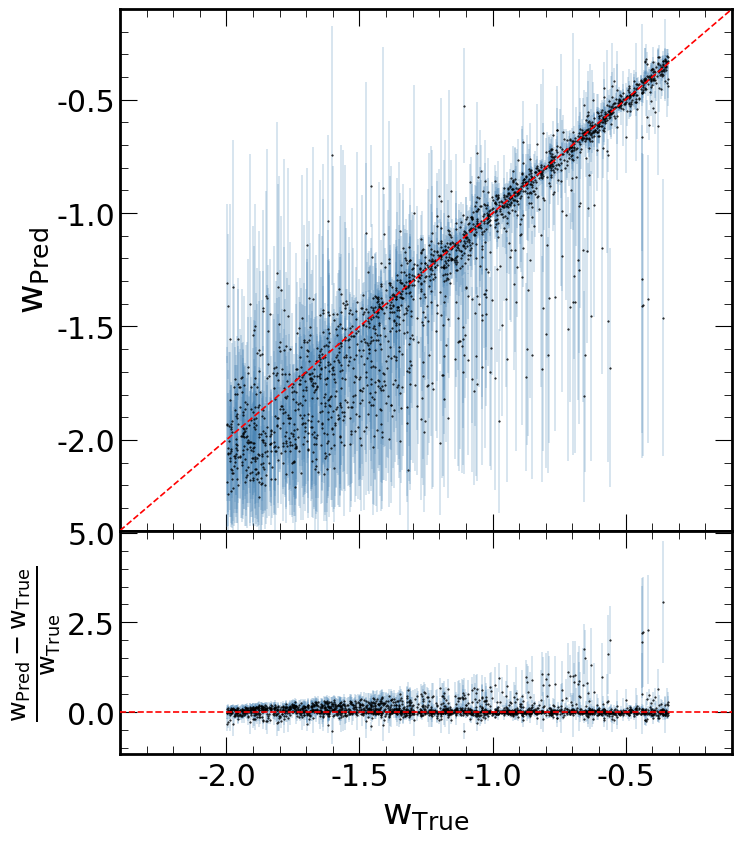

In [40]:
# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 9), sharex=True, sharey=False, height_ratios=[0.7,0.3], gridspec_kw={'hspace': 0.0, 'wspace': 0.0})
ax1.grid(False)
ax2.grid(False)

# Plot for the first subplot
ax1.plot([-2.4, -0.1], [-2.4, -0.1], 'r--', zorder=3, lw=1.2)
ax1.set_xlim(-2.4, -0.1)
ax1.set_ylim(-2.4, -0.1)

ax1.errorbar(true_test_theta[0:2000], posteriors_all[:,0], yerr=posteriors_all[:,1], fmt='o', zorder=2, markersize=0.5, linewidth=0.3, mec='k', mfc='k', ecolor='steelblue')

ax1.set_ylabel(r'$ \mathrm{w_{Pred}}$')

# Plot for the second subplot
ax2.plot([-2.4, -0.1], [0,0], 'r--', zorder=3, lw=1.2)
ax2.errorbar(true_test_theta[0:2000], (posteriors_all[:,0]-true_test_theta[0:2000])/true_test_theta[0:2000], yerr=posteriors_all[:,1]/abs(true_test_theta[0:2000]), fmt='o', zorder=2, markersize=0.5, linewidth=0.3, mec='k', mfc='k', ecolor='steelblue')
ax2.set_ylabel(r'$ \frac{\mathrm{w_{Pred}} - \mathrm{w_{True}}}{\mathrm{w_{True}}}$')
ax2.set_xlabel(r'$ \mathrm{w_{True}}$')
ax2.set_xlim(-2.4, -0.1)

# Show the plot
plt.tight_layout()
plt.savefig('residual_plot_xtest_2000_v2.pdf', dpi=400, bbox_inches='tight')
plt.show()

### Calculate the Posterior Coverage Plot

In [57]:
def calculate_coverage_fraction_density_estimator(posterior_prob, thetas, truth_array, percentile_list):
    '''
    Function to calculate the posteiror coverage fraction

    Inputs:
    posterior_prob: Posterior probability distribution
    thetas: A list of w values in a range
    truth_array: The list of true w values
    Percentile_list: The percentile list from 0 to 100

    Outputs:
    The fraction of lenses within the confidence interval
    '''
    # sample from posterior probability
    count_array = []
    for i in range(0, 2000):
        sampled_values = np.random.choice(thetas, size=1000, p=posterior_prob[i])
        count_vector = []
        for ind, cov in enumerate(percentile_list):
            percentile_l = 50.0 - cov/2
            percentile_u = 50.0 + cov/2 
            confidence_l = np.percentile(sampled_values,percentile_l,axis=0)
            confidence_u = np.percentile(sampled_values,percentile_u,axis=0)
            # print(confidence_l, confidence_u)
            count = np.logical_and(confidence_u - truth_array[i] > 0, truth_array[i] - confidence_l > 0)
            count_vector.append(count)
        count_array.append(count_vector)
    count_sum_array = np.sum(count_array, axis=0)
    frac_lens_within_vol = np.array(count_sum_array)
    return frac_lens_within_vol/2000
        

In [58]:
# Calculate the posterior converage plot
percentile_array = np.linspace(0,100,21)
coverage_fraction = calculate_coverage_fraction_density_estimator(posterior_all_samples, sample_theta, true_test_theta[0:2000], percentile_array)


Shape of fraction array:  (21,)


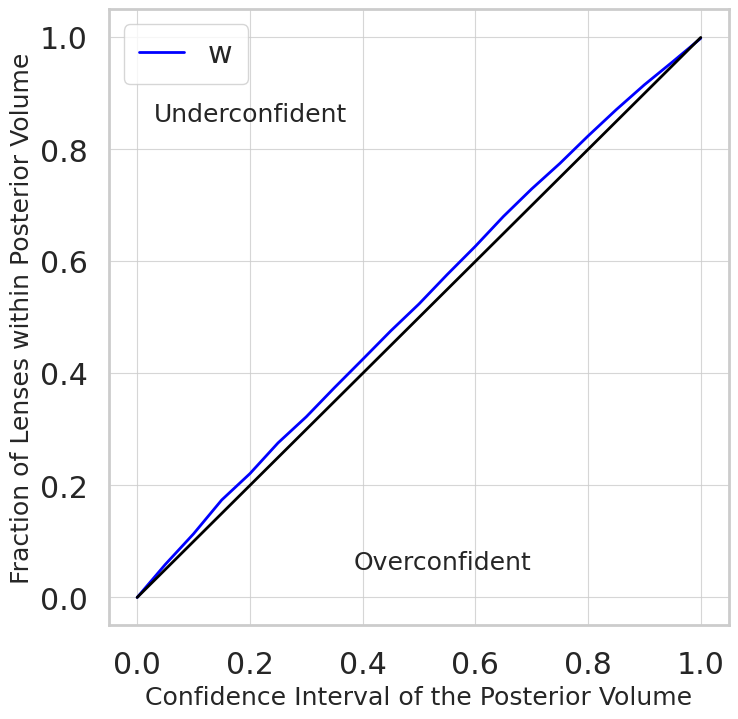

In [75]:
# Plot the Posterior Coverage plot

print('Shape of fraction array: ', np.shape(coverage_fraction))
    
percentile_array_norm = np.array(percentile_array)/100

default_cycler = (cycler(color='bgrcmyk') *
                    cycler(linestyle=['-', '-.']))

plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=default_cycler)
sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1,figsize=(8, 8))
plt.plot(percentile_array_norm, coverage_fraction)
plt.legend('w', loc='upper left')
plt.plot([0,0.5,1],[0,0.5,1], 'k-', zorder=1000)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.text(0.03,0.85,'Underconfident',horizontalalignment='left', fontsize='x-small')
plt.text(0.7,0.05,'Overconfident',horizontalalignment='right', fontsize='x-small')
plt.xlabel('Confidence Interval of the Posterior Volume', fontsize='x-small')
plt.ylabel('Fraction of Lenses within Posterior Volume', fontsize='x-small')

ax.tick_params(axis='both', which='both', labelsize='small')
# plt.tight_layout()
# plt.savefig(results_path+results_name+'_'+'posterior_coverage.pdf')
plt.show()

In [78]:
# select only theta values and corresponing predicted values for theta > -1.5

inx = np.where(true_test_theta[0:2000] > -1.5)
theta_2 = true_test_theta[0:2000][inx]
posteriors_all_2 = posteriors_all[inx]

In [89]:
# calculate a similar plot from the residual values i.e. from predicted - true/ error_true

residuals = (posteriors_all_2[:,0] - theta_2)/posteriors_all_2[:,1]
sigma_intervals = np.linspace(0, 3, 21)
num_samples = []
for sigma in sigma_intervals:
    num_samples.append(np.sum(np.abs(residuals) < sigma)/len(residuals))
num_samples = np.array(num_samples)

In [ ]:
import scipy.stats as stats

# Function to calculate the percentage of values within a given sigma range
def percentage_within_sigma(sigma):
    lower_bound = -sigma
    upper_bound = sigma
    cdf_lower = stats.norm.cdf(lower_bound)
    cdf_upper = stats.norm.cdf(upper_bound)
    percentage = (cdf_upper - cdf_lower) * 100
    return percentage

# Calculate the percentages for each sigma value
percentages = [percentage_within_sigma(sigma) for sigma in sigma_intervals]
fraction_of_percentages = np.array(percentages)/100

# Print the results
for sigma, percentage in zip(sigma_intervals, percentages):
    print(f"{sigma:.3f} sigma: {percentage:.2f}%")

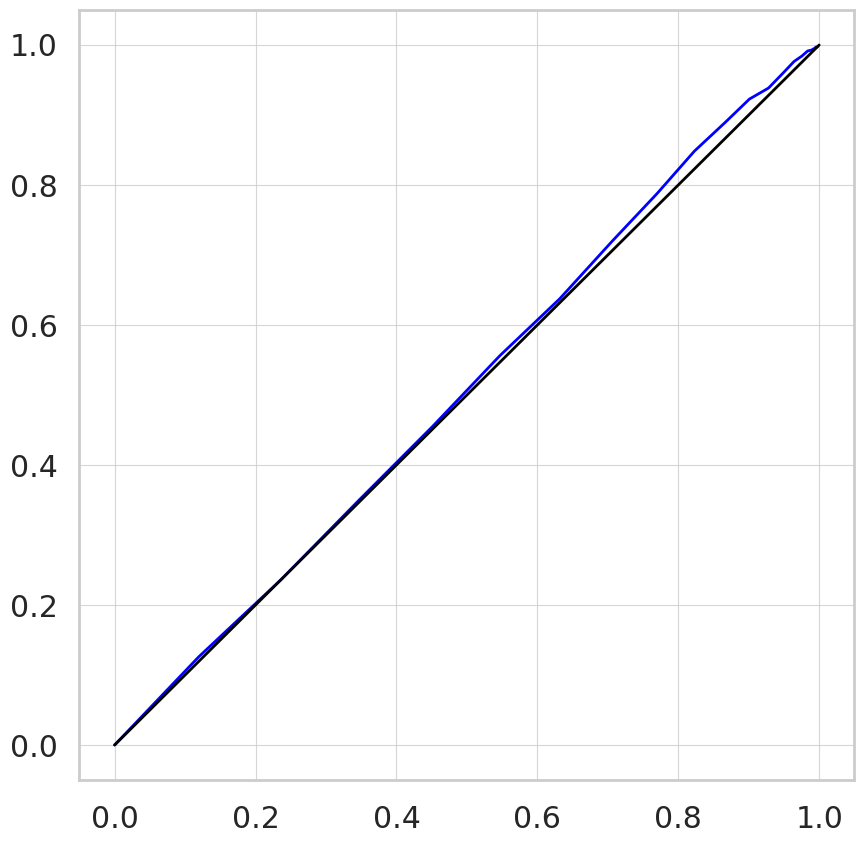

In [103]:
plt.plot(fraction_of_percentages, num_samples)
plt.plot([0,0.5,1],[0,0.5,1], 'k-', zorder=1000)

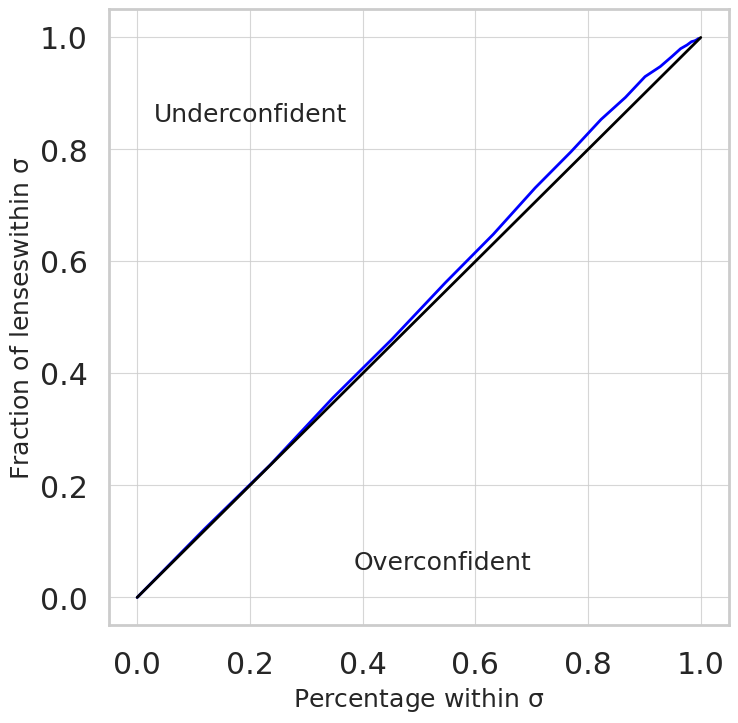

In [108]:
# similar plot from all the residuals in the w range [-2.0, -0.34]

residuals = (posteriors_all[:,0] - true_test_theta[0:2000])/posteriors_all[:,1]
sigma_intervals = np.linspace(0, 3, 21)
num_samples = []
for sigma in sigma_intervals:
    num_samples.append(np.sum(np.abs(residuals) < sigma)/len(residuals))
num_samples = np.array(num_samples)

# Calculate the percentages for each sigma value
percentages = [percentage_within_sigma(sigma) for sigma in sigma_intervals]
fraction_of_percentages = np.array(percentages)/100

fig, ax = plt.subplots(1,1,figsize=(8, 8))
plt.plot(fraction_of_percentages, num_samples)
plt.plot([0,0.5,1],[0,0.5,1], 'k-', zorder=1000)

plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.text(0.03,0.85,'Underconfident',horizontalalignment='left', fontsize='x-small')
plt.text(0.7,0.05,'Overconfident',horizontalalignment='right', fontsize='x-small')
plt.xlabel(r'$Percentage\ within\ \sigma$', fontsize='x-small')
plt.ylabel(r'$Fraction\ of\ lenses within\ \sigma$', fontsize='x-small')

plt.show()

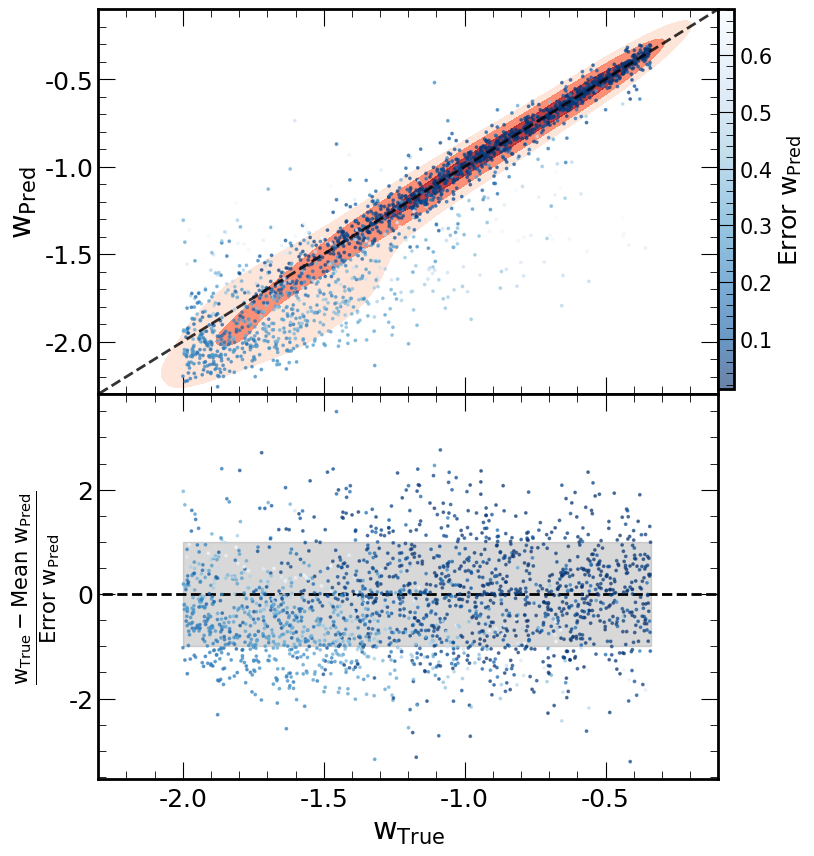

In [28]:
# The residual version of the parity plot

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

# Axes 1 with scatter plot and color bar

sc = ax1.scatter(true_test_theta[:2000], posteriors_all[:,0], c=posteriors_all[:,1],cmap='Blues_r', alpha=0.6, zorder=3, s=3)
# Create a separate axis for the color bar
cbar_ax = fig.add_axes([0.9, 0.5, 0.02, 0.38])  # Adjust position and size of the color bar axis

# Create the color bar using the pre-defined axis
cb = fig.colorbar(sc, cax=cbar_ax, ax=ax1, label=r'$ Error\ \mathrm{w_{Pred}}$')
cb.ax.yaxis.label.set_fontsize('x-small')
cb.ax.yaxis.set_tick_params(labelsize='xx-small')

# Get the original colormap
# original_cmap = plt.cm.Purples
original_cmap = plt.cm.Reds
kde = sns.kdeplot(x=true_test_theta[:2000], y=posteriors_all[:,0], cmap='Reds', thresh=0.2, levels=[0.2, 0.5, 0.8, 1.0], 
                  ax=ax1, zorder=0,fill=True, alpha=0.8)

ax1.plot([-4.0, -0.1], [-4.0, -0.1], 'k--', zorder=3, linewidth=2.0, alpha=0.8)
ax1.set_ylabel(r'$ \mathrm{w_{Pred}}$', fontsize='small')
ax1.set_xlim(-2.3, -0.1)
ax1.set_ylim(-2.3, -0.1)
ax1.tick_params(axis='both', which='both', labelsize='x-small')

# Axes 2 with residual plot

ax2.plot([-4.0, -0.1], [0, 0], 'k--', zorder=3, linewidth=2.0)

ax2.fill_between([np.min(true_test_theta[0:2000]), np.max(true_test_theta[0:2000])], [-1, -1], [1, 1], color='gray', alpha=0.3)
ax2.scatter(true_test_theta[:2000], (posteriors_all[:,0] - true_test_theta[0:2000]) / posteriors_all[:,1], c=posteriors_all[:,1], 
            cmap='Blues_r', alpha=0.6, zorder=3, s=3)

ax2.set_ylabel(r'$ \frac{\mathrm{w_{True}} - Mean\ \mathrm{w_{Pred}}}{Error\ \mathrm{w_{Pred}}}$', fontsize='small')
ax2.set_xlabel(r'$ \mathrm{w_{True}}$', fontsize='small')
ax2.tick_params(axis='both', which='both', labelsize='x-small')

fig.subplots_adjust(hspace=0)
# plt.savefig('residual_plot_xtest_2000.pdf', bbox_inches='tight')
# plt.tight_layout()

plt.show()